# Explainable AI

So far, we learned how to train and evaluate classifiers. Now, we would like to understand why the classifiers make the predictions the way they do. For instance, we want to know, what variables are important in predicting whether an employee visits the website or exits, or whether a customer would renew her/ his subscription ...

In this notebook, we look into several methods that would help us better understand, interpret, and explain the results of classifiers. We divide these methods into:

* Feature ranking
* Feature selection (Boruta, RFE, ...)
* Logistic regression
* Shapley

To be able to use these methods, we first need to develop a classifier. Below, we first develop a vanilla XGBoost classifier using McAfee data. We then use feature ranking, feature selection, logistic regression, and Shapley to better understand the model and its predictions. 

## 1. Develop the Classifier:

#### 1.1. Notebook Stpip install -U numpyyling and Package Management

In [1]:
import numpy as np # Library for math operations
import pandas as pd # Library for data handling
import sklearn # The machine learning library we will be using in this entire course
from sklearn import tree # Tree function is used for visualizing decision tree
from sklearn.metrics import * # Importing function that can be used to calculate different metrics
from sklearn.tree import DecisionTreeClassifier # Importing Decision Tree Classifier 
from sklearn.ensemble import RandomForestClassifier  # Importing Random Forest Classifier 
from sklearn.model_selection import train_test_split # Importing function that can split a dataset into training and testing set
from sklearn.preprocessing import MinMaxScaler # Importing function for scaling the data
from sklearn.preprocessing import LabelEncoder # Importing function for processing the labels
from sklearn.ensemble import GradientBoostingClassifier # Importing GB Classifier
from sklearn.model_selection import GridSearchCV # Importing GridSearchCV
from sklearn.model_selection import RandomizedSearchCV # Importing RandomSearchCV
from xgboost import XGBClassifier # Importing the XGBoost Classifier 
import matplotlib.pyplot as plt # Importing the package for plotting
plt.style.use('fivethirtyeight') # Use the styling from FiveThirtyEight Website
import seaborn as sns # Importing another package for plotting

#### 1.2. Load Data

In [2]:
trainInput = pd.read_csv("Data/Phishing_TrainSample.csv").sample(frac=1, 
                                                                 random_state=1) 
testInput = pd.read_csv("Data/Phishing_TestSample.csv")

In [3]:
trainData = trainInput.drop(columns = 'Visit')
trainLabels = LabelEncoder().fit_transform(trainInput.Visit)

testData = testInput.drop(columns = 'Visit')
testLabels = LabelEncoder().fit_transform(testInput.Visit)

#### 1.3. Train a XGBoost Classifier

In [4]:
clf = XGBClassifier(random_state = 1)
clf.fit(trainData, trainLabels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

#### 1.4. Evaluate the Classifier Using the Testing Data

In [5]:
from custom_functions import plot_conf_mat, plot_roc_curve, plot_feature_importance, calculateMetricsAndPrint

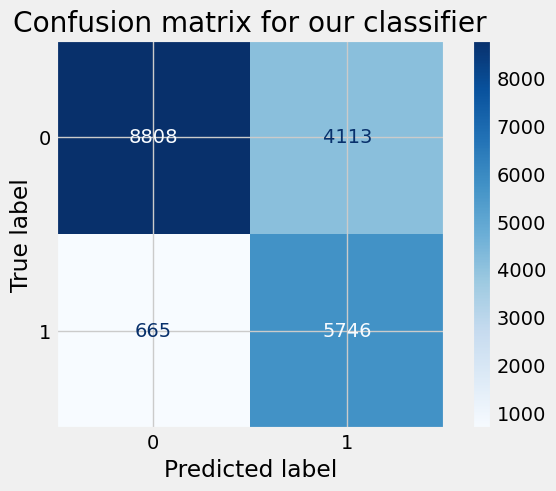

In [6]:
plot_conf_mat(clf, # The classifier object
              testData, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

In [7]:
predictedProbabilities = clf.predict_proba(testData)
predictedLabels = clf.predict(testData) 
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)

Accuracy: 75.28
PrecisionNegative: 92.98
PrecisionPositive: 58.28
RecallNegative: 68.17
RecallPositive: 89.63
AUC Score: 86.30



In [8]:
print("F1 Score:",f1_score(testLabels, predictedLabels, average='micro'))

F1 Score: 0.7528450237947445


AUC Score = 86.302


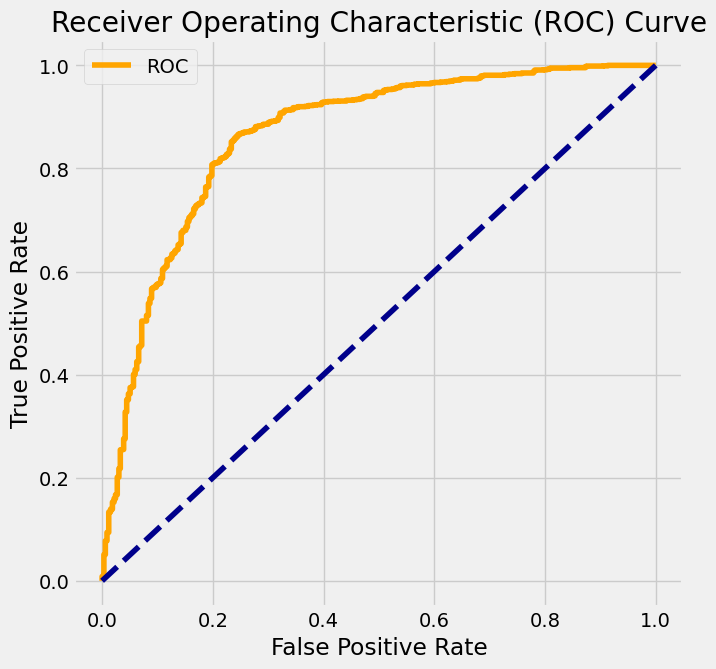

In [9]:
positiveProbabilities = predictedProbabilities[:,1]
plot_roc_curve(testLabels, # Actual labels
               positiveProbabilities, # Prediction scores for the positive class
               pos_label = 1 # Indicate the label that corresponds to the positive class
              )

Now, we go ahead and try the different methods in explainable AI:

## 2. Feature Ranking

Feature ranking helps us understand the relative importance of variables in predicting the target variable (e.g., Visit). For XGBoost, we can use the plot_importance method:

We can change importance_type (str, default "weight") – How the importance is calculated: either “weight”, “gain”, or “cover”
* ”weight” is the number of times a feature appears in a tree
* ”gain” is the average gain of splits which use the feature
* ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

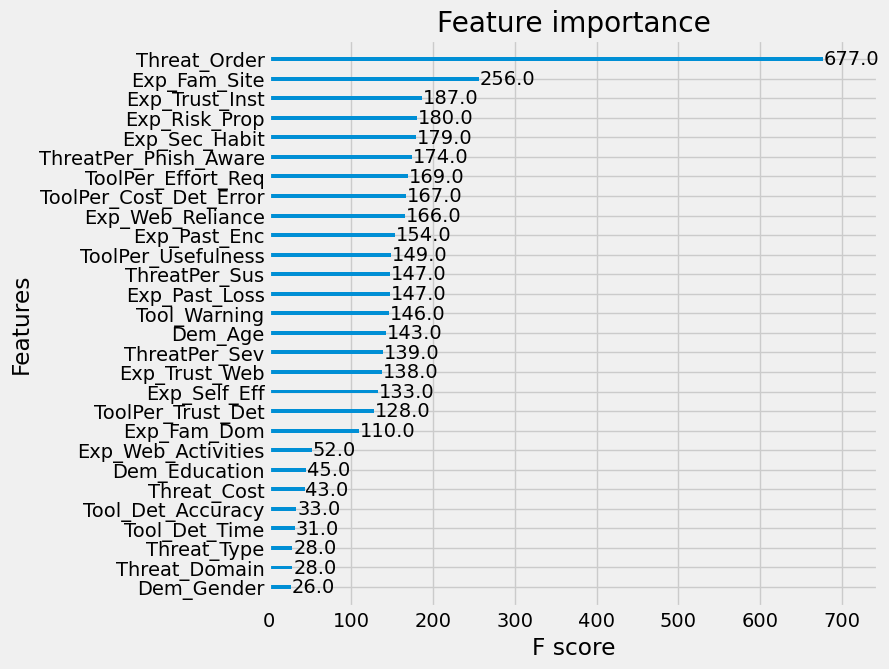

In [10]:
from xgboost import plot_importance

# plot feature importance
plot_importance(clf, importance_type = "weight")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

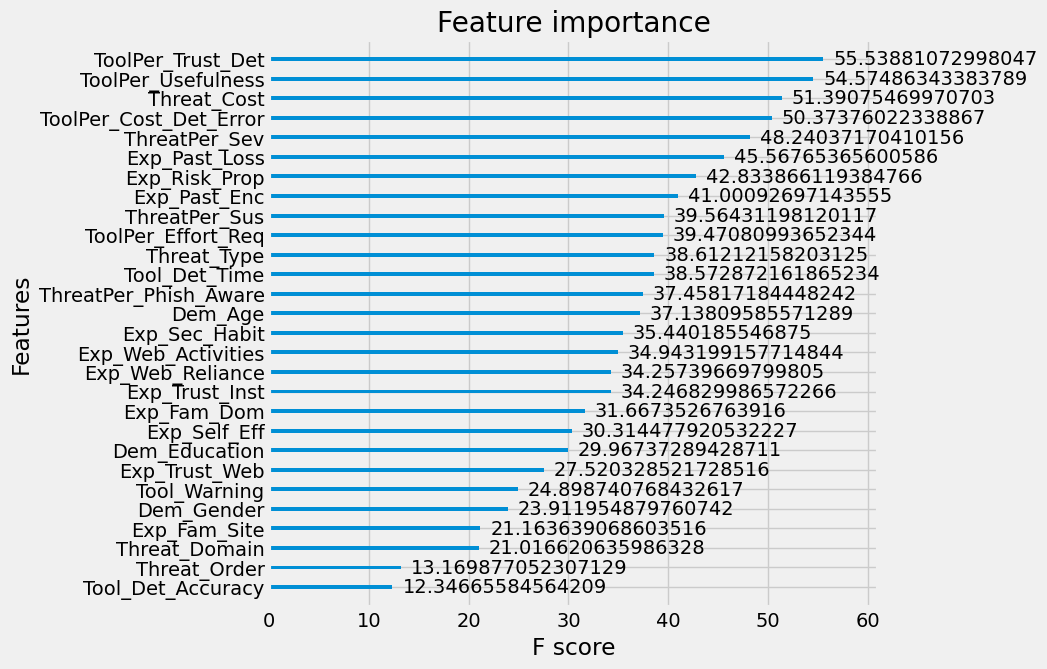

In [11]:
from xgboost import plot_importance

# plot feature importance
plot_importance(clf, importance_type = "gain")

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

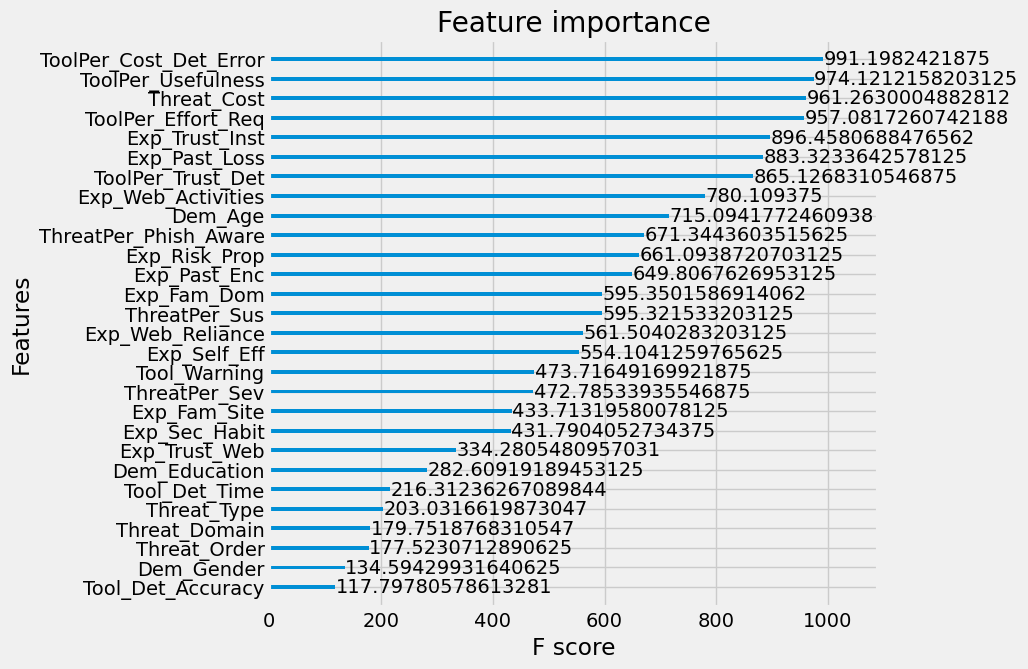

In [12]:
from xgboost import plot_importance

# plot feature importance
plot_importance(clf, importance_type = "cover")

As we can see, different types of feature importances result in different results. Another issue with this method, is that we cannot figure out whether a feature/ variable is *sufficiently* important in predicting the target. To address these issues, we can use feature selection methods such as RFE and Boruta: 

## 3. Feature Selection Methods

### 3.1. Recursive Feature Engineering (RFE)

The goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [13]:
from sklearn.feature_selection import RFE

selector = RFE(clf, n_features_to_select=5, # Max number of features desired
               step=1)
selector = selector.fit(trainData, trainLabels)
rfe_results = pd.DataFrame({"Feature":trainData.columns,"Selected":selector.support_})
rfe_results.sort_values('Selected', ascending = False)

,Feature,Selected
4,Threat_Cost,True
23,Exp_Fam_Dom,True
22,ToolPer_Trust_Det,True
21,ToolPer_Usefulness,True
20,ToolPer_Cost_Det_Error,True
0,Tool_Det_Accuracy,False
15,ThreatPer_Phish_Aware,False
26,Threat_Order,False
25,Exp_Web_Activities,False
24,Exp_Fam_Site,False


We can also see the ranks of the variables:

In [14]:
rfe_results = pd.DataFrame({"Feature":trainData.columns,"Rank":selector.ranking_})
rfe_results.sort_values('Rank', ascending = True)

,Feature,Rank
21,ToolPer_Usefulness,1
23,Exp_Fam_Dom,1
4,Threat_Cost,1
22,ToolPer_Trust_Det,1
20,ToolPer_Cost_Det_Error,1
19,ToolPer_Effort_Req,2
18,Exp_Self_Eff,3
17,ThreatPer_Sev,4
16,ThreatPer_Sus,5
15,ThreatPer_Phish_Aware,6


### 3.2. Boruta

Boruta is another method for finding importnat features in a classification model. It uses a smart method to compare each feature with a list of *shadow* features that are created using a random shuffle of the original features. The idea is that each real feature should be a better predictor than the shadow features. If so, Boruta will suggest that the feature is important (Confirmed). Otherwise, the feature is not important.

In [15]:
! pip install boruta

In [16]:
from boruta import BorutaPy

In [17]:
# let's initialize Boruta
feat_selector = BorutaPy(
    verbose=2,
    estimator=clf,
    n_estimators='auto',
    max_iter=10  # number of iterations to perform
)

np.int = np.int32
np.float = np.float64
np.bool = np.bool_
# train Boruta
# N.B.: X and y must be numpy arrays
feat_selector.fit(np.array(trainData),np.array(trainLabels))

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	28
Tentative: 	0
Rejected: 	0


BorutaPy finished running.

Iteration: 	9 / 10
Confirmed: 	28
Tentative: 	0
Rejected: 	0


BorutaPy(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                                 colsample_bylevel=None, colsample_bynode=None,
                                 colsample_bytree=None, device=None,
                                 early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 feature_types=None, gamma=None,
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None,
                                 learning_rate=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 multi_strategy=None, n_estimators=74,
                                 n_jobs=None, num_parallel_tree=None,
                                 random_state=529627002, ...),
         max_iter=10, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FEA6C168740, verbose=2)

In [18]:
boruta_results = pd.DataFrame({"Feature":trainData.columns,"Selected":feat_selector.support_})
boruta_results.sort_values('Selected', ascending = False)

,Feature,Selected
0,Tool_Det_Accuracy,True
1,Tool_Det_Time,True
26,Threat_Order,True
25,Exp_Web_Activities,True
24,Exp_Fam_Site,True
23,Exp_Fam_Dom,True
22,ToolPer_Trust_Det,True
21,ToolPer_Usefulness,True
20,ToolPer_Cost_Det_Error,True
19,ToolPer_Effort_Req,True


In [19]:
boruta_results = pd.DataFrame({"Feature":trainData.columns,"Rank":feat_selector.ranking_})
boruta_results.sort_values('Rank', ascending = True)

,Feature,Rank
0,Tool_Det_Accuracy,1
25,Exp_Web_Activities,1
24,Exp_Fam_Site,1
23,Exp_Fam_Dom,1
22,ToolPer_Trust_Det,1
21,ToolPer_Usefulness,1
20,ToolPer_Cost_Det_Error,1
19,ToolPer_Effort_Req,1
18,Exp_Self_Eff,1
17,ThreatPer_Sev,1


We can see that according to Boruta, all of the features are important and should be included in the analysis. 

## 4. Logistic Regression

Another way to evaluate the importance of each feature is through obtaining the p-value of the corresponding coefficient for the feature in a logistic regression model. To do this, we first fit a logistic regression model. We then investigate the coefficients and the p-values to determine important features:

In [20]:
import statsmodels.api as sm

In [21]:
X = sm.add_constant(trainData)
log_reg = sm.Logit(trainLabels, X).fit()

Optimization terminated successfully.
         Current function value: 0.568827
         Iterations 6


In [22]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                54384
Model:                          Logit   Df Residuals:                    54355
Method:                           MLE   Df Model:                           28
Date:                Wed, 10 Jan 2024   Pseudo R-squ.:                  0.1199
Time:                        23:05:12   Log-Likelihood:                -30935.
converged:                       True   LL-Null:                       -35149.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.7194      0.092     -7.781      0.000      -0.901      -0.538
Tool_Det_Accuracy         -0.1067      0.022     -4.891      0.000      -0.149      -0.064
Tool

In the output, the features that have a p-value of 0.05 or less are important features. As we can see, the majority of the features have a p-value below 0.05. Therefore, they are important features. 

Another benefit of the logistic regression is the sign of the coefficients. The positive sign means that the increase in the feature is associated with increase in the target (e.g. visit = 1). A negative sign for the coefficient means that increase in the value of that feature is associated with a decrease in the target.

For instance, increase in Tool_Det_Accuracy is associated with decrease in visit (employees are less likely to click on the phishing link to visit the website when the tool accuracy is high). However, increase in Exp_Web_Reliance is associated with increase in visit (employees are more likely to click on the phishing link to visit the website when employee's web reliance is high).

NOTE: Given that the features in the logistic regression model could be highly correlated, it is better to separately check the sign of each coefficient by running a logistic regression with only one predictor:

In [23]:
# For Tool_Det_Accuracy:
X = sm.add_constant(trainData[['Tool_Det_Accuracy']])

log_reg = sm.Logit(trainLabels, X).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.637435
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                54384
Model:                          Logit   Df Residuals:                    54382
Method:                           MLE   Df Model:                            1
Date:                Wed, 10 Jan 2024   Pseudo R-squ.:                 0.01375
Time:                        23:05:12   Log-Likelihood:                -34666.
converged:                       True   LL-Null:                       -35149.
Covariance Type:            nonrobust   LLR p-value:                3.700e-212
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.3132      0.013    -23.499      0.000      -0.339      -0.287
Tool_Det

In [24]:
# For Exp_Web_Reliance:
X = sm.add_constant(trainData[['Exp_Web_Reliance']])
                    
log_reg = sm.Logit(trainLabels, X).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.645607
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                54384
Model:                          Logit   Df Residuals:                    54382
Method:                           MLE   Df Model:                            1
Date:                Wed, 10 Jan 2024   Pseudo R-squ.:                0.001102
Time:                        23:05:12   Log-Likelihood:                -35111.
converged:                       True   LL-Null:                       -35149.
Covariance Type:            nonrobust   LLR p-value:                 1.341e-18
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.0230      0.046    -22.143      0.000      -1.114      -0.932
Exp_Web_Rel

After investigating the importance of the features in the classifier, we can use visualization techniques to visually inspect potential relationships:

/opt/conda/lib/python3.11/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


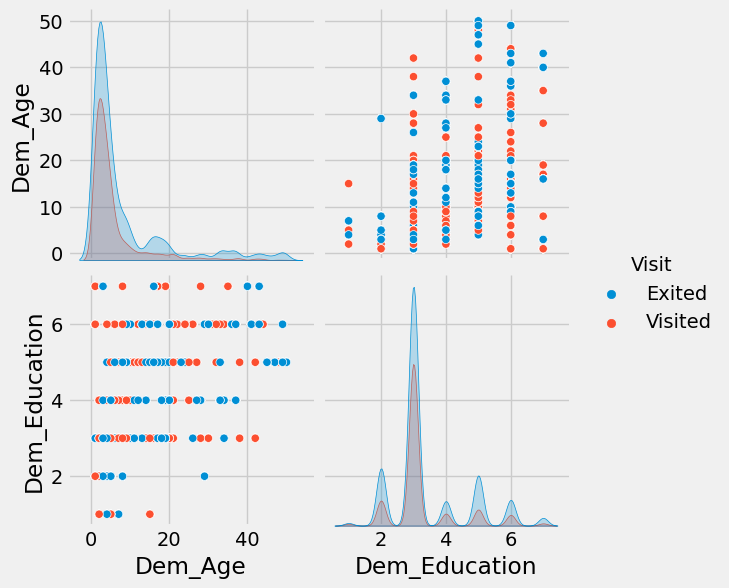

In [25]:
import seaborn as sns

sns.pairplot(trainInput[['Dem_Age','Dem_Education','Visit']], hue="Visit", size=3);
plt.show()

## 5. Shapley Scores:

So far, we know how to evaluate the predictive performance of our model, and we know which features/ variables are more important in predicting the target. But, what if we want to know how these predictors influence the prediction scores for each individual employee? For instance, we might be interested in learning why an employee intends to visit or exit. Is it due to Age, Gender, or Education? Is it due to tool-related features? 
For this type of analysis, we can use a few methods. The two main methods that are implemented in Python are Lime and Shapely. Here, we learn about Shapely and the logic behind the Shapely scores. 

A prediction can be explained by assuming that each variable (feature) is a "player" in a game where the prediction is the payout. The "game" is the prediction task for a single instance of the dataset. The "gain" is the actual prediction for this instance minus the average prediction for all instances. The "players" are the variables (columns) that collaborate to receive the gain (= predict a certain value). Shapley values -- a method from coalitional game theory -- tells us how to fairly distribute the "payout" among the variables. Players cooperate in a coalition and receive a certain profit from this cooperation. Players that contribute more, will get more payout. 

Shapley visualizes variable contributions as "forces". Each variable value is a force that either increases or decreases the prediction score. The prediction starts from the baseline. The baseline for Shapley values is the average of all predictions. In the plot, each Shapley value is an arrow that pushes to increase (positive value) or decrease (negative value) the prediction. These forces balance each other out at the actual prediction of the data instance.

Let's go ahead and give it a try:

In [26]:
clf = XGBClassifier(objective = "binary:logistic", random_state = 1)
clf.fit(trainData, trainLabels)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

In [27]:
import shap

shap.initjs() # Please do not change this. We use this to create the Shapley plots.
explainer = shap.TreeExplainer(clf) # PLEASE DO NOT CHANGE THIS.

[23:05:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Shapley can now calculate the scores for each row in our trainData:

In [28]:
shapValues = np.array(explainer.shap_values(trainData))

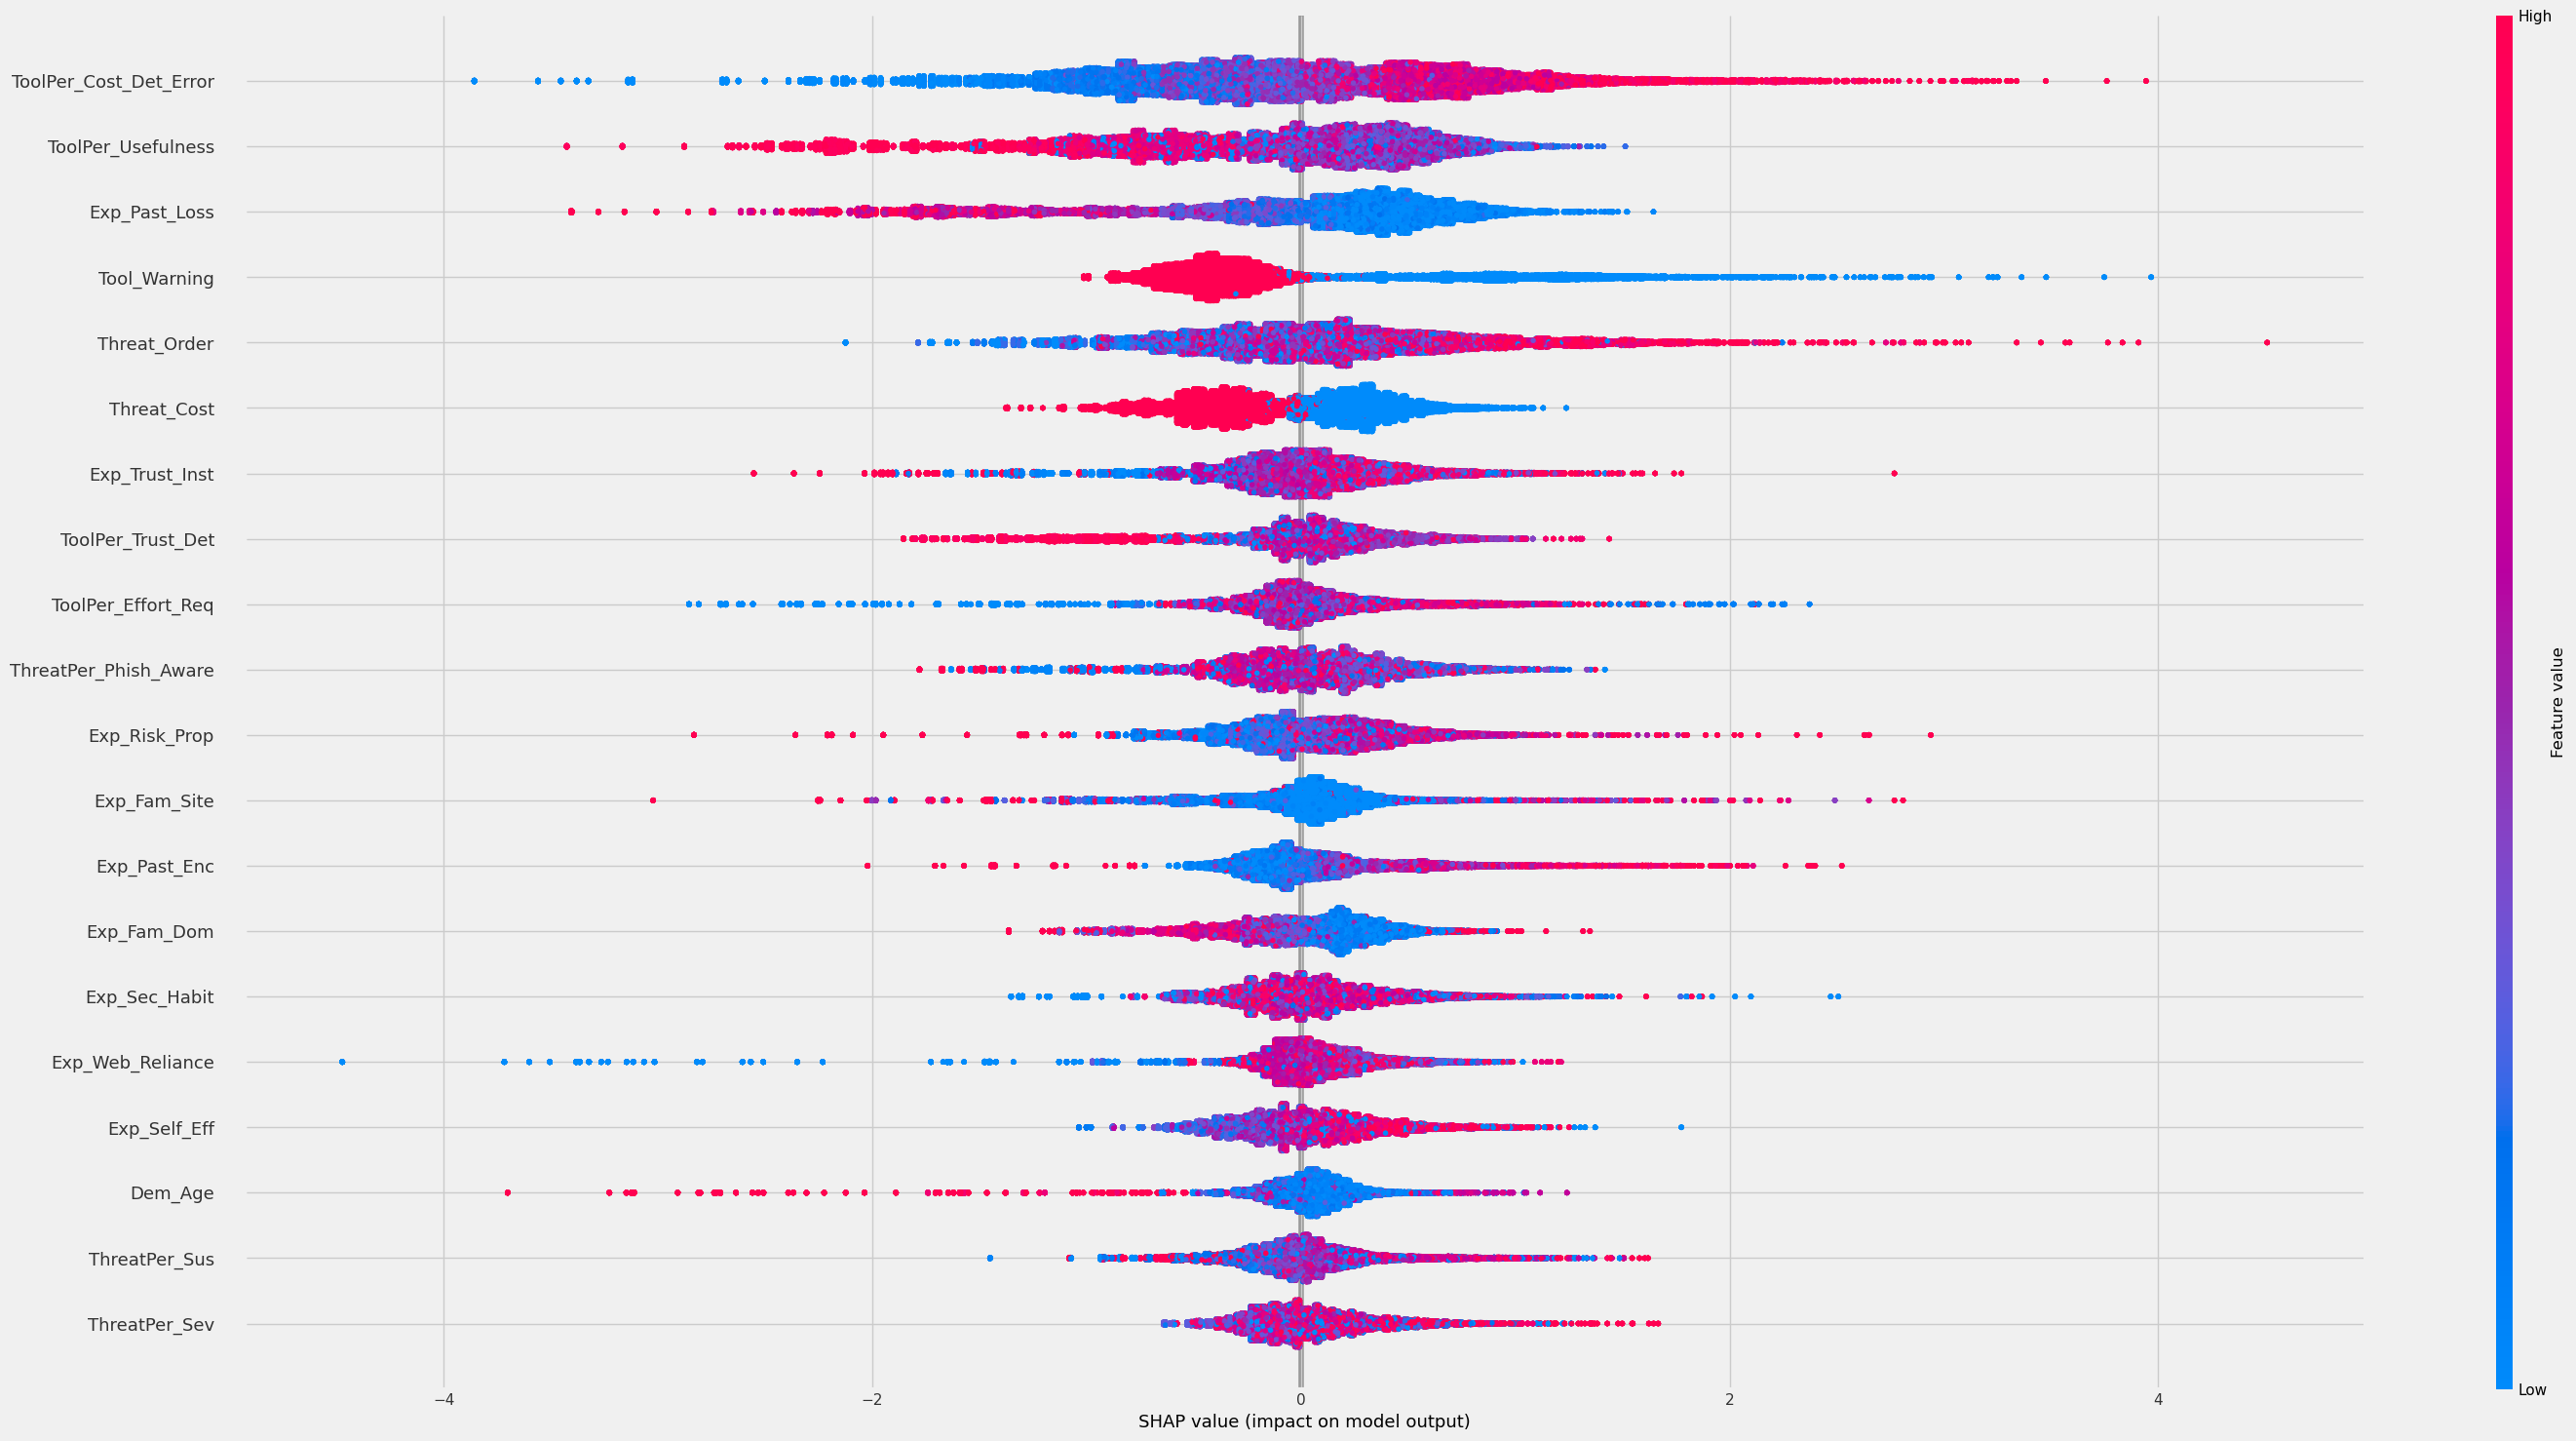

In [29]:
plt_shap = shap.summary_plot(shapValues, #Use Shap values array
                             features=trainData, # Use training set features
                             feature_names=trainData.columns, #Use column names
                             # show=False, #Set to false to output to folder
                             plot_size=(30,15)) # Change plot size

Now, let's go ahead and create the Shapley plot for the first row in the profile data: 

In [30]:
explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(trainData)

index = 0 # Row index, 0
shap.force_plot(explainer.expected_value, shap_values[index,:], 
                trainData.iloc[index,:])

[23:05:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Each red bar shows to what extent a variable is working to increase the prediction score for this employee. Each blue bar shows to what extent a variable is working to decrease the score. The length of the bars represents the magnitude of impact by each variable, and they all add up to the Shapley score. The numbers you see in front of each variable is the value of the row for that variable.    

To better visualize the Shap values for each row in the data, we can use the bar plot. Below, we recalculate the Shap values for trainData and then visualize the Shap values for the first row in trainData:  

[23:05:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[23:05:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


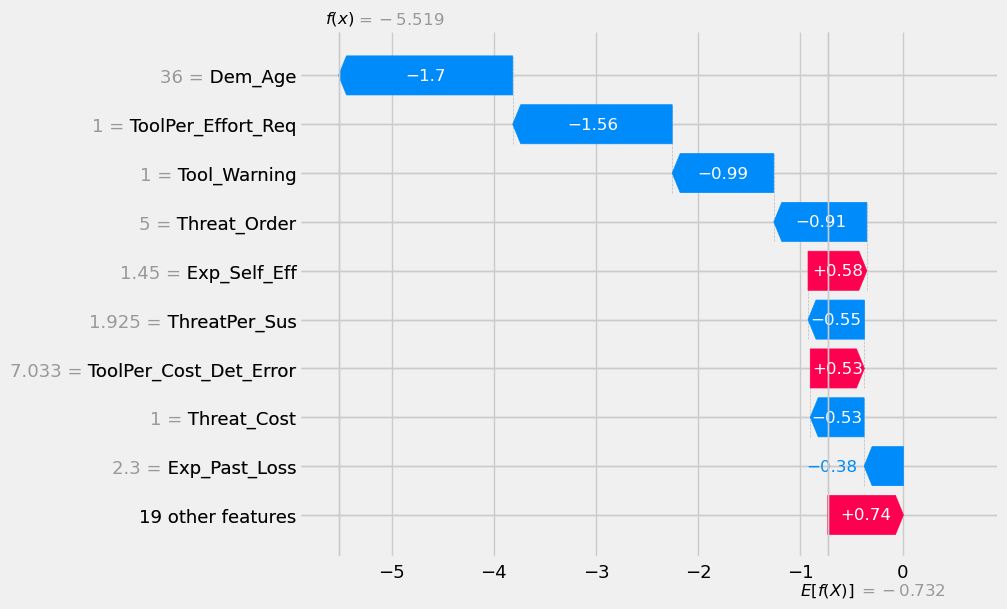

In [31]:
explainer = shap.Explainer(clf)
shap_values = explainer(trainData)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

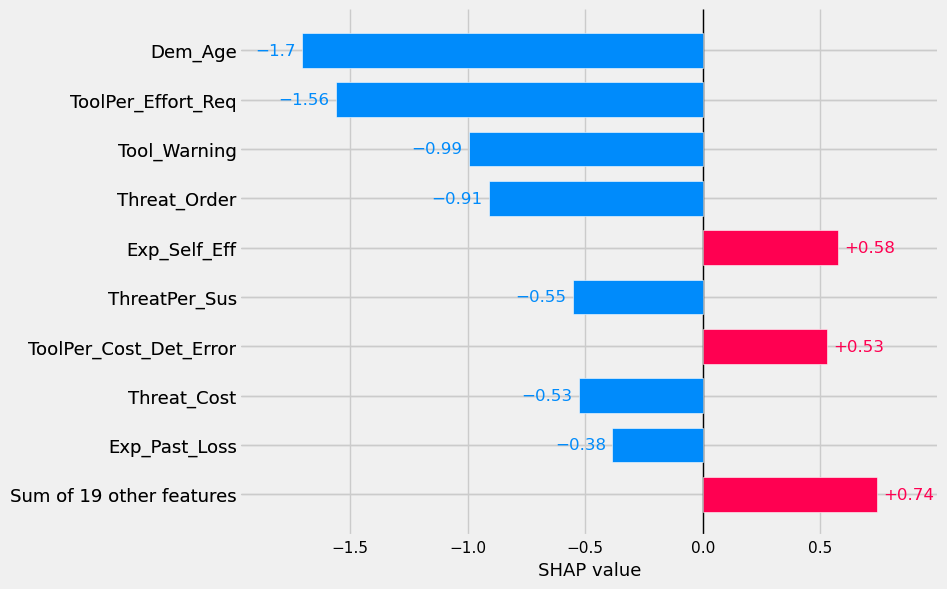

In [32]:
shap.plots.bar(shap_values[0])

Shapley's force_plot can be used to visualize the scores for multiple data points. In the example below, we visualize the Shapley scores for the first 100 data points in trainData:

In [33]:
shap.force_plot(explainer.expected_value, shapValues[:100,:], trainData.iloc[:100,:])

## 6. Exploring Data Using SQL:

One of the cool features of Python is its integration with other programming languages such as SQL. Using Python package pandasql, we can query, filter, and transform data in SQL before or after a machine learning task. Below, we demonstrate how to set up pandasql and run a couple of simple SQL queries.

In [34]:
!pip install pandasql

In [35]:
from pandasql import sqldf
import pandas as pd

pysqldf = lambda q: sqldf(q, globals())
df = pd.read_csv("Data/Phishing_TrainSample.csv")
df.head(3)

,Visit,Tool_Det_Accuracy,Tool_Det_Time,Threat_Domain,Threat_Type,Threat_Cost,Dem_Gender,Dem_Age,Dem_Education,Exp_Web_Reliance,...,Exp_Self_Eff,ToolPer_Effort_Req,ToolPer_Cost_Det_Error,ToolPer_Usefulness,ToolPer_Trust_Det,Exp_Fam_Dom,Exp_Fam_Site,Exp_Web_Activities,Threat_Order,Tool_Warning
0,Visited,0,0,0,0,1,1,2,2,9.166667,...,8.75,7.000,8.500000,5.000,5.00,2.0,1.0,4,8,0
1,Visited,0,1,0,1,0,0,4,4,7.666667,...,7.25,1.875,3.000000,1.525,1.30,1.0,1.0,7,3,1
2,Visited,1,1,1,0,0,0,1,3,8.666667,...,7.50,2.700,2.633333,8.000,7.75,8.0,1.0,4,10,0


In [36]:
q1 = """SELECT * 
       FROM df 
       LIMIT 3;"""

pysqldf(q1)

,Visit,Tool_Det_Accuracy,Tool_Det_Time,Threat_Domain,Threat_Type,Threat_Cost,Dem_Gender,Dem_Age,Dem_Education,Exp_Web_Reliance,...,Exp_Self_Eff,ToolPer_Effort_Req,ToolPer_Cost_Det_Error,ToolPer_Usefulness,ToolPer_Trust_Det,Exp_Fam_Dom,Exp_Fam_Site,Exp_Web_Activities,Threat_Order,Tool_Warning
0,Visited,0,0,0,0,1,1,2,2,9.166667,...,8.75,7.000,8.500000,5.000,5.00,2.0,1.0,4,8,0
1,Visited,0,1,0,1,0,0,4,4,7.666667,...,7.25,1.875,3.000000,1.525,1.30,1.0,1.0,7,3,1
2,Visited,1,1,1,0,0,0,1,3,8.666667,...,7.50,2.700,2.633333,8.000,7.75,8.0,1.0,4,10,0


In [37]:
q2 = """SELECT * 
       FROM df 
       WHERE Visit == 'Exited' AND Tool_Det_Accuracy == 1;"""

pysqldf(q2)

,Visit,Tool_Det_Accuracy,Tool_Det_Time,Threat_Domain,Threat_Type,Threat_Cost,Dem_Gender,Dem_Age,Dem_Education,Exp_Web_Reliance,...,Exp_Self_Eff,ToolPer_Effort_Req,ToolPer_Cost_Det_Error,ToolPer_Usefulness,ToolPer_Trust_Det,Exp_Fam_Dom,Exp_Fam_Site,Exp_Web_Activities,Threat_Order,Tool_Warning
0,Exited,1,0,1,1,0,0,1,3,8.000000,...,6.325,1.000,1.500000,8.625,8.000,1.7,1.0,4,7,1
1,Exited,1,1,0,0,1,1,3,3,7.000000,...,8.450,3.550,6.866667,8.075,7.050,1.6,1.0,7,5,1
2,Exited,1,0,1,0,0,0,3,3,5.066667,...,3.000,5.225,4.966667,2.850,4.575,6.7,1.2,6,3,1
3,Exited,1,1,1,1,1,0,16,7,8.033333,...,5.850,2.975,3.333333,7.675,8.025,7.6,1.9,5,8,1
4,Exited,1,0,1,0,0,0,3,3,3.833333,...,7.775,3.300,3.466667,7.475,5.900,5.0,1.2,7,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22115,Exited,1,1,1,1,1,1,4,2,5.400000,...,3.725,6.400,5.900000,5.875,5.475,1.3,3.7,5,10,1
22116,Exited,1,1,1,1,1,1,45,5,4.533333,...,5.000,2.500,3.633333,7.175,7.525,1.0,1.0,3,1,1
22117,Exited,1,1,1,1,1,1,45,5,4.533333,...,5.000,2.500,3.633333,7.175,7.525,1.0,1.0,3,2,1
22118,Exited,1,1,1,1,1,1,45,5,4.533333,...,5.000,2.500,3.633333,7.175,7.525,1.0,1.0,3,4,1


## 7. iModels:

imodels packs cutting-edge techniques for concise, transparent, and accurate predictive modelling. The Python library, created by researchers at UC Berkeley, provides a simple interface for fitting and using state-of-the-art interpretable models. Interpretable models are often difficult to use and implement. iModels fills this gap with a simple unified interface and implementation for many state-of-the-art interpretable modelling techniques. For the documentations, please visit https://github.com/csinva/imodels

In [38]:
!pip install imodels==1.3.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.3/195.3 kB 4.0 MB/s eta 0:00:0000:01
  Attempting uninstall: imodels
    Found existing installation: imodels 1.4.1
    Uninstalling imodels-1.4.1:
      Successfully uninstalled imodels-1.4.1


In [39]:
from imodels import HSTreeClassifierCV # import any imodels model here

# fit the model
model = HSTreeClassifierCV(max_leaf_nodes=6)  # initialize a tree model and specify only 4 leaf nodes
model.fit(trainData, trainLabels, 
          feature_names=list(trainData.columns))   # fit model
preds = model.predict(testData) # discrete predictions: shape is (n_test, 1)
preds_proba = model.predict_proba(testData) # predicted probabilities: shape is (n_test, n_classes)
print(model) # print the model

X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but Dec

> ------------------------------
> Decision Tree with Hierarchical Shrinkage
> 	Prediction is made by looking at the value in the appropriate leaf of the tree
> ------------------------------
|--- feature_21 <= 7.06
|   |--- feature_24 <= 1.25
|   |   |--- feature_8 <= 5.10
|   |   |   |--- weights: [0.77, 0.23] class: 0.0
|   |   |--- feature_8 >  5.10
|   |   |   |--- feature_27 <= 0.50
|   |   |   |   |--- weights: [0.33, 0.67] class: 1.0
|   |   |   |--- feature_27 >  0.50
|   |   |   |   |--- weights: [0.54, 0.46] class: 0.0
|   |--- feature_24 >  1.25
|   |   |--- weights: [0.66, 0.34] class: 0.0
|--- feature_21 >  7.06
|   |--- feature_27 <= 0.50
|   |   |--- weights: [0.59, 0.41] class: 0.0
|   |--- feature_27 >  0.50
|   |   |--- weights: [0.82, 0.18] class: 0.0



X has feature names, but DecisionTreeClassifier was fitted without feature names
X has feature names, but DecisionTreeClassifier was fitted without feature names


## 8. Explainer Dashboard

**Note: This section is included for those who want to try this on their local machine or another cloud environment. The output cannot be displayed if you are running this notebook on Darden's JupyterHub.**

Explainer Dashboard (explainerdashboard) is a library for quickly building interactive dashboards for analyzing and explaining the predictions and workings of (scikit-learn compatible) machine learning models, including xgboost, catboost and lightgbm. This makes your model transparant and explainable with just two lines of code.

It allows us to investigate SHAP values, permutation importances, interaction effects, partial dependence plots, all kinds of performance plots, and even individual decision trees inside a random forest. With explainerdashboard any data scientist can create an interactive explainable AI web app in minutes, without having to know anything about web development or deployment.

You first install the package, import it, and construct an explainer object out of your model and the test data:

In [40]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [41]:
!pip install explainerdashboard

In [42]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
explainer = ClassifierExplainer(clf, testData, testLabels)

Detected XGBClassifier model: Changing class type to XGBClassifierExplainer...
Note: model_output=='probability'. For XGBClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...


/opt/conda/lib/python3.11/site-packages/dash/_jupyter.py:31: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
/opt/conda/lib/python3.11/site-packages/jupyter_dash/comms.py:10: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:06:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1703076519788/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [43]:
ExplainerDashboard(explainer, mode='inline').run(port=8051)

Building ExplainerDashboard..


/opt/conda/lib/python3.11/site-packages/dash/dash.py:538: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



For this type of model and model_output interactions don't work, so setting shap_interaction=False...
Generating layout...
Calculating shap values...


100%|===================| 19318/19332 [01:18<00:00]        

Calculating prediction probabilities...
Calculating metrics...
Calculating confusion matrices...
Calculating classification_dfs...
Calculating roc auc curves...
Calculating pr auc curves...
Calculating liftcurve_dfs...
Generating xgboost model dump...
Calculating dependencies...
Calculating permutation importances (if slow, try setting n_jobs parameter)...
Calculating pred_percentiles...
Calculating predictions...
Calculating ShadowDecTree for each individual decision tree...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard inline (terminate it with ExplainerDashboard.terminate(8051))


/opt/conda/lib/python3.11/site-packages/jupyter_dash/jupyter_app.py:310: DeprecationWarning:

setDaemon() is deprecated, set the daemon attribute instead



In [44]:
ExplainerDashboard().terminate(8051)

Building ExplainerDashboard..


ValueError: The NoneType was generated with a version of explainerdashboard<0.3 and therefore not compatible with this version of ExplainerDashboard due to breaking changes in between major versions! Please rebuild your NoneType with this version, or downgrade back to explainerdashboard==0.2.20.1!